In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import cv2
AUTOTUNE = tf.data.AUTOTUNE
from tensorflow.keras.applications.efficientnet import preprocess_input

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import random
import time
import pickle
import os, glob, cv2, numpy as np
from sklearn.metrics import (
    cohen_kappa_score, accuracy_score, f1_score,
    confusion_matrix, classification_report
)

2025-08-14 21:21:39.446371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 21:21:39.570515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755220899.617650    5812 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755220899.632956    5812 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755220899.736959    5812 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
             
TARGET_SIZE = 448                  # ảnh đầu ra (h = w = 600)
APPLY_CIRCULAR_MASK = True         # che góc đen
DO_CROP_FOV = True                 # crop sát vùng võng mạc trước khi resize
MARGIN_CIRCLE = 4                  # rìa trống khi vẽ mask tròn
METHOD = "clahe_green"              # "ben_graham" | "clahe_lab" | "clahe_green"
def crop_fov(img, thr=10):
    """Crop sát vùng võng mạc: xác định bbox của các pixel > thr (loại biên đen)."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray > thr
    if not np.any(mask):
        return img
    ys, xs = np.where(mask)
    y0, y1 = int(ys.min()), int(ys.max())
    x0, x1 = int(xs.min()), int(xs.max())
    # phòng hờ biên
    y0 = max(0, y0-2); x0 = max(0, x0-2)
    y1 = min(img.shape[0]-1, y1+2); x1 = min(img.shape[1]-1, x1+2)
    return img[y0:y1+1, x0:x1+1]

def apply_circular_mask(img, margin=MARGIN_CIRCLE):
    """Giữ vùng tròn trung tâm, che góc đen cho ảnh võng mạc."""
    h, w = img.shape[:2]
    r = min(h, w)//2 - margin
    if r <= 0:
        return img
    cx, cy = w//2, h//2
    mask = np.zeros((h, w), np.uint8)
    cv2.circle(mask, (cx, cy), r, 255, -1)
    out = cv2.bitwise_and(img, img, mask=mask)
    return out
def preprocess_clahe_lab(bgr, clip=2.0, tile=(8,8)):
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    l2 = clahe.apply(l)
    lab2 = cv2.merge([l2, a, b])
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

def preprocess_clahe_green(bgr, clip=2.0, tile=(8,8)):
    g = bgr[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    g2 = clahe.apply(g)
    # replicate sang 3 kênh để giữ đầu vào 3-channels cho backbone
    return cv2.merge([g2, g2, g2])
def preprocess_ben_graham(bgr, sigma=10):
    """
    Ben Graham preprocessing: giảm non-uniform illumination.
    Công thức phổ biến: out = 4*img - 4*GaussianBlur(img, sigma) + 128
    """
    gb = cv2.GaussianBlur(bgr, (0, 0), sigmaX=sigma, sigmaY=sigma)
    out = cv2.addWeighted(bgr, 4.0, gb, -4.0, 128)
    return np.clip(out, 0, 255).astype(np.uint8)


def resize_square(img, size=TARGET_SIZE):
    return cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

def process_one(img_bgr):
    x = img_bgr
    # 1) Crop vùng FOV (loại viền đen, cắt gọn)
    if DO_CROP_FOV:
        x = crop_fov(x, thr=10)
    # 2) Resize tạm về vuông để mask tròn đẹp
    x = resize_square(x, TARGET_SIZE)
    # 3) Chọn 1 trong các phương pháp tiền xử lý
    if METHOD == "ben_graham":
        x = preprocess_ben_graham(x, sigma=10)
    elif METHOD == "clahe_lab":
        x = preprocess_clahe_lab(x, clip=2.0, tile=(8,8))
    elif METHOD == "clahe_green":
        x = preprocess_clahe_green(x, clip=2.0, tile=(8,8))
    else:
        # không chọn → giữ nguyên
        pass
    # 4) (tuỳ chọn) Circular mask để che góc
    if APPLY_CIRCULAR_MASK:
        x = apply_circular_mask(x, margin=MARGIN_CIRCLE)
    # 5) Đảm bảo kích thước đầu ra
    x = resize_square(x, TARGET_SIZE)
    return x


In [3]:
model=tf.keras.models.load_model('models/effb4_eyespacs2015_dualhead_stage1.keras')

I0000 00:00:1755010495.202458   10228 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1210 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


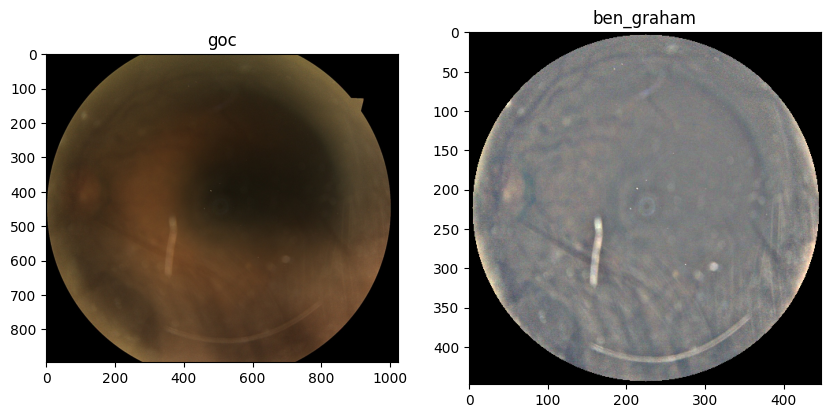

In [5]:


img = cv2.imread("eyepacs_2015/train/184_left.jpeg", cv2.IMREAD_COLOR)
img =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
proc = process_one(img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img)
ax1.set_title('goc')

ax2.imshow(proc)
ax2.set_title('ben_graham')

plt.show()

In [ ]:
pre=model.predict(img)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[array([[4.2653683e-04, 4.8970757e-03, 1.3493660e-03, 3.5325411e-01,
        6.4007294e-01]], dtype=float32), array([[0.9970259 , 0.9691871 , 0.99631053, 0.8593225 ]], dtype=float32)]
[0 0 0 0 0]


In [42]:
print(pre[0])
print(np.argmax(pre[0][0],axis=0))

[[4.2653683e-04 4.8970757e-03 1.3493660e-03 3.5325411e-01 6.4007294e-01]]
4


In [9]:
TEST_DIR = "/home/duc/Documents/DoAn/messidor/train"          # test/0..4
CLASS_NAMES = ["0","1","2","3","4"]

IMAGE_SIZE = 448           # khớp với lúc train (448/512)
BATCH_SIZE = 8
SEED = 42

ALPHA_FUSE = 0.1           # tỉ lệ trộn: p_final = α*softmax + (1-α)*ordinal_dist
MODEL_PATH = "models/effb4_eyespacs2015_dualhead_v3_stage4.keras"  

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
# ================= CHo da tien xu ly anh=====================
def make_test_ds(data_dir=TEST_DIR):
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="int",
        class_names=CLASS_NAMES,
        color_mode="rgb",
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False,              # test: không shuffle
        seed=SEED
    )
       # Hàm xử lý bằng OpenCV chạy trên NumPy
   
    # Chuẩn hoá giống lúc train (EfficientNet preprocess_input)
    def _map(x, y):
        
        x = tf.cast(x, tf.float32)
        x = preprocess_input(x)
        return x, y
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds

def cum_to_dist(cum4):
    """
    cum4: (N,4) với [p>=1, p>=2, p>=3, p>=4]
    -> (N,5) phân phối lớp [0..4]
    """
    p_ge1, p_ge2, p_ge3, p_ge4 = [cum4[:, i] for i in range(4)]
    p0 = 1.0 - p_ge1
    p1 = p_ge1 - p_ge2
    p2 = p_ge2 - p_ge3
    p3 = p_ge3 - p_ge4
    p4 = p_ge4
    P = np.stack([p0, p1, p2, p3, p4], axis=1)
    # Chặn âm do không đơn điệu tuyệt đối, rồi renorm
    P = np.clip(P, 1e-7, None)
    P = P / P.sum(axis=1, keepdims=True)
    return P

def predict_dual(model, ds, alpha=ALPHA_FUSE):
    """Trả về y_true, p_soft, p_from_ord, p_final, y_pred_*"""
    y_true = []
    for _, y in ds:
        y_true.append(y.numpy())
    y_true = np.concatenate(y_true, axis=0)

    # model.predict với dataset (x,y) sẽ chỉ dùng x; đầu ra: [softmax, ordinal]
    preds = model.predict(ds, verbose=1)
    p_soft = preds[0]        # (N,5)
    cum4   = preds[1]        # (N,4)
    p_ord  = cum_to_dist(cum4)

    if alpha <= 1e-8:
        p_final = p_ord
    elif alpha >= 0.9999:
        p_final = p_soft
    else:
        p_final = alpha * p_soft + (1.0 - alpha) * p_ord
        p_final = p_final / p_final.sum(axis=1, keepdims=True)  # renorm

    y_pred_soft  = p_soft.argmax(axis=1)
    y_pred_ord   = p_ord.argmax(axis=1)
    y_pred_final = p_final.argmax(axis=1)

    return y_true, p_soft, p_ord, p_final, y_pred_soft, y_pred_ord, y_pred_final

def print_main_metrics(y_true, p_final, y_pred_final):
    """Phương pháp mình chọn: QWK + Acc + Macro-F1 (trên dự đoán hợp nhất)"""
    qwk  = cohen_kappa_score(y_true, y_pred_final, weights="quadratic")
    acc  = accuracy_score(y_true, y_pred_final)
    f1m  = f1_score(y_true, y_pred_final, average="macro")
    print("\n====== MAIN METRICS (Fused) ======")
    print(f"Quadratic Weighted Kappa : {qwk:.5f}")
    print(f"Accuracy                 : {acc:.5f}")
    print(f"Macro F1                 : {f1m:.5f}")
    print("\nClassification report (per-class):")
    print(classification_report(y_true, y_pred_final, digits=4))

def show_confusion(y_true, y_pred, normalize=False):
    """Confusion matrix với sklearn.metrics.confusion_matrix"""
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4], normalize='true' if normalize else None)
    print("\n====== CONFUSION MATRIX ======")
    print("(Hàng: nhãn thật, Cột: nhãn dự đoán)")
    print(np.array2string(cm, formatter={'float_kind':lambda x: f"{x:6.3f}"} if normalize else None))

    # (Tuỳ chọn) vẽ heatmap bằng matplotlib
    plt.figure(figsize=(6,5))
    im = plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix ({'normalized' if normalize else 'counts'})")
    plt.colorbar(im)
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, CLASS_NAMES)
    plt.yticks(tick_marks, CLASS_NAMES)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    # Ghi số trong ô (nếu không normalize)
    if not normalize:
        for i in range(5):
            for j in range(5):
                plt.text(j, i, int(cm[i, j]), ha="center", va="center", fontsize=9, color="w" if cm.max()>0 and cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout()
    plt.show()

In [6]:
# ================= Chua tien xu ly anh=====================
def make_test_ds(data_dir=TEST_DIR):
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="int",
        class_names=CLASS_NAMES,
        color_mode="rgb",
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=None,
        shuffle=False,              # test: không shuffle
        seed=SEED
    )
       # Hàm xử lý bằng OpenCV chạy trên NumPy
    # 2) Xử lý 1 ảnh bằng OpenCV (chạy trong numpy_function)
    def _cv2_preprocess_np(img_rgb_np):
        import numpy as np, cv2

        # Bảo vệ nếu vô tình là ảnh xám (2D hoặc 1 kênh)
        if img_rgb_np.ndim == 2:
            img_rgb_np = cv2.cvtColor(img_rgb_np, cv2.COLOR_GRAY2RGB)
        elif img_rgb_np.shape[-1] == 1:
            img_rgb_np = np.repeat(img_rgb_np, 3, axis=-1)

        # RGB -> BGR cho pipeline OpenCV của bạn
        img_bgr = img_rgb_np[..., ::-1]

        # Gọi process_one (kỳ vọng BGR)
        out_bgr = process_one(img_bgr)      # trả về BGR

        # BGR -> RGB cho keras
        out_rgb = out_bgr[..., ::-1]

        # Đảm bảo đúng kích thước cho model
        out_rgb = cv2.resize(out_rgb, (IMAGE_SIZE, IMAGE_SIZE))

        # Luôn trả uint8
        return out_rgb.astype(np.uint8)
    # Chuẩn hoá giống lúc train (EfficientNet preprocess_input)
    def _map(x, y):
        
        x = tf.numpy_function(_cv2_preprocess_np, [x], tf.uint8)
        x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
        x = tf.cast(x, tf.float32)
        x = preprocess_input(x)
        return x, y
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

def cum_to_dist(cum4):
    """
    cum4: (N,4) với [p>=1, p>=2, p>=3, p>=4]
    -> (N,5) phân phối lớp [0..4]
    """
    p_ge1, p_ge2, p_ge3, p_ge4 = [cum4[:, i] for i in range(4)]
    p0 = 1.0 - p_ge1
    p1 = p_ge1 - p_ge2
    p2 = p_ge2 - p_ge3
    p3 = p_ge3 - p_ge4
    p4 = p_ge4
    P = np.stack([p0, p1, p2, p3, p4], axis=1)
    # Chặn âm do không đơn điệu tuyệt đối, rồi renorm
    P = np.clip(P, 1e-7, None)
    P = P / P.sum(axis=1, keepdims=True)
    return P

def predict_dual(model, ds, alpha=ALPHA_FUSE):
    """Trả về y_true, p_soft, p_from_ord, p_final, y_pred_*"""
    y_true = []
    for _, y in ds:
        y_true.append(y.numpy())
    y_true = np.concatenate(y_true, axis=0)

    # model.predict với dataset (x,y) sẽ chỉ dùng x; đầu ra: [softmax, ordinal]
    preds = model.predict(ds, verbose=1)
    p_soft = preds[0]        # (N,5)
    cum4   = preds[1]        # (N,4)
    p_ord  = cum_to_dist(cum4)

    if alpha <= 1e-8:
        p_final = p_soft
    elif alpha >= 0.9999:
        p_final = p_ord
    else:
        p_final = alpha * p_soft + (1.0 - alpha) * p_ord
        p_final = p_final / p_final.sum(axis=1, keepdims=True)  # renorm

    y_pred_soft  = p_soft.argmax(axis=1)
    y_pred_ord   = p_ord.argmax(axis=1)
    y_pred_final = p_final.argmax(axis=1)

    return y_true, p_soft, p_ord, p_final, y_pred_soft, y_pred_ord, y_pred_final

def print_main_metrics(y_true, p_final, y_pred_final):
    """Phương pháp mình chọn: QWK + Acc + Macro-F1 (trên dự đoán hợp nhất)"""
    qwk  = cohen_kappa_score(y_true, y_pred_final, weights="quadratic")
    acc  = accuracy_score(y_true, y_pred_final)
    f1m  = f1_score(y_true, y_pred_final, average="macro")
    print("\n====== MAIN METRICS (Fused) ======")
    print(f"Quadratic Weighted Kappa : {qwk:.5f}")
    print(f"Accuracy                 : {acc:.5f}")
    print(f"Macro F1                 : {f1m:.5f}")
    print("\nClassification report (per-class):")
    print(classification_report(y_true, y_pred_final, digits=4))

def show_confusion(y_true, y_pred, normalize=False):
    """Confusion matrix với sklearn.metrics.confusion_matrix"""
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4], normalize='true' if normalize else None)
    print("\n====== CONFUSION MATRIX ======")
    print("(Hàng: nhãn thật, Cột: nhãn dự đoán)")
    print(np.array2string(cm, formatter={'float_kind':lambda x: f"{x:6.3f}"} if normalize else None))

    # (Tuỳ chọn) vẽ heatmap bằng matplotlib
    plt.figure(figsize=(6,5))
    im = plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix ({'normalized' if normalize else 'counts'})")
    plt.colorbar(im)
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, CLASS_NAMES)
    plt.yticks(tick_marks, CLASS_NAMES)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    # Ghi số trong ô (nếu không normalize)
    if not normalize:
        for i in range(5):
            for j in range(5):
                plt.text(j, i, int(cm[i, j]), ha="center", va="center", fontsize=9, color="w" if cm.max()>0 and cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout()
    plt.show()

Found 1744 files belonging to 5 classes.
218/218 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step

====== MAIN METRICS (Fused) ======
Quadratic Weighted Kappa : 0.63182
Accuracy                 : 0.52007
Macro F1                 : 0.50435

Classification report (per-class):
              precision    recall  f1-score   support

           0     0.7931    0.5388    0.6417      1017
           1     0.2083    0.3889    0.2713       270
           2     0.4672    0.5130    0.4890       347
           3     0.4240    0.7067    0.5300        75
           4     0.5349    0.6571    0.5897        35

    accuracy                         0.5201      1744
   macro avg     0.4855    0.5609    0.5044      1744
weighted avg     0.6166    0.5201    0.5481      1744


====== CONFUSION MATRIX ======
(Hàng: nhãn thật, Cột: nhãn dự đoán)
[[548 335 129   0   5]
 [108 105  53   2   2]
 [ 35  64 178  62   8]
 [  0   0  17  53   5]
 [  0   0   4   8  23]]


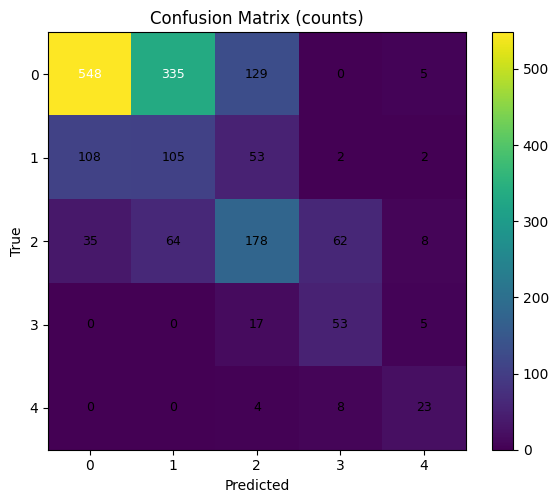

In [10]:

model = tf.keras.models.load_model(MODEL_PATH, compile=False)

    # 2) Tạo test dataset
ds_test = make_test_ds(TEST_DIR)

    # 3) Dự đoán
y_true, p_soft, p_ord, p_final, y_pred_soft, y_pred_ord, y_pred_final = predict_dual(model, ds_test, alpha=ALPHA_FUSE)

    # 4) ĐÁNH GIÁ CHÍNH (mình chọn): QWK + Acc + Macro-F1 (dùng dự đoán hợp nhất)
print_main_metrics(y_true, p_final, y_pred_final)

    # 5) CONFUSION MATRIX (đếm số lượng)
show_confusion(y_true, y_pred_final, normalize=False)

In [23]:
!ipynb-py-convert test_model.ipynb test.py